<a href="https://colab.research.google.com/github/solarslurpi/GrowBuddies/blob/main/growbuddiesproject/growbuddies/drgrowbuddy/pre_processing_image_data_for_drgrowbuddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[zipfile library documentation](https://docs.python.org/3/library/zipfile.html)
# Goals
The goals of this notebook:
- Identify a subset of images from the  [the PlantVillage Dataset in Papers With Code](https://paperswithcode.com/dataset/plantvillage). The subset of images is to include 1000 images of healthy plant leaves and 1000 images of unhealthy plant leaves.
- Download the subset of data to use.
- Load the dataset into a PyTorch dataloader.
- Determine the datasets to be used for our first Deep Learning model.  The task is for the model to predict whether a leaf is healthy or not healthy.  I'm starting here as a way to constrain the full space down to a very small - hence easier to understand - subset of the data.
- Gain skills in the pre-processing of datasets workflow.  

## Downloading the Dataset
I downloaded the dataset to my Google drive from [this source](https://data.mendeley.com/datasets/tywbtsjrjv/1).  There is both an augmented and without augmentation.  I am not interested in with augmentation.  The dataset downloaded is Plant_leaf_diseases_dataset_without_augmentation.zip.




There seems to be a gahzillion packages and small companies offering APIs for downloading datasets in their "data lake" and then getting them into PyTorch data loaders.  I went down that path.  The main one I used was with AIloop ...but I ran into bugs.
Now I'm using the method described [in this medium article](https://medium.com/towards-data-science/pro-tip-for-downloading-custom-datasets-in-colab-environment-5413896d14ec).

# Look at the images
The easiest way to get a good visual feel for the data is to look at the images is through [the activeloop platform](https://app.activeloop.ai/activeloop/plantvillage-without-augmentation/08130113ea9ac322dbefc20d26797defa682a87f?vs=eyJsaSI6eyJjIjpbeyJoIjpmYWxzZSwibiI6ImltYWdlcyIsIm8iOjEuMH0seyJoIjpmYWxzZSwibiI6ImxhYmVscyIsIm8iOjAuNjk5OTk5OTg4MDc5MDcxfV0sImgiOmZhbHNlLCJuIjoiZGVmYXVsdCIsIm8iOjEuMH0sInJpIjp7ImNmIjpbLTEuMCwwLjAsMC4wXSwiY2kiOlswLjAsLTMuMTQxNTkyNzQxMDEyNTczMl0sImNtIjoxLjAsImNwIjpbNC4wLDEuMTAwMDAwMDIzODQxODU4LC0xLjA5OTk5ODQ3NDEyMTA5MzhdLCJvaSI6MjY0NDZ9fQ==).  There is over 52,000 images.  The number of images is overwhelming.

# Copy the dataset from my drive into colab
## Get access to google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Load the Zip file into colab.

## List the Different Classes
Each folder in the dataset has the class name.  I got this list from [structure section](https://app.activeloop.ai/activeloop/plantvillage-without-augmentation/08130113ea9ac322dbefc20d26797defa682a87f?vs=eyJsaSI6eyJjIjpbeyJoIjpmYWxzZSwibiI6ImltYWdlcyIsIm8iOjEuMH0seyJoIjpmYWxzZSwibiI6ImxhYmVscyIsIm8iOjAuNjk5OTk5OTg4MDc5MDcxfV0sImgiOmZhbHNlLCJuIjoiZGVmYXVsdCIsIm8iOjEuMH0sInJpIjp7ImNmIjpbLTEuMCwwLjAsMC4wXSwiY2kiOlswLjAsLTMuMTQxNTkyNzQxMDEyNTczMl0sImNtIjoxLjAsImNwIjpbNC4wLDEuMTAwMDAwMDIzODQxODU4LC0xLjA5OTk5ODQ3NDEyMTA5MzhdLCJvaSI6MjY0NDZ9fQ==)





<img src=https://raw.githubusercontent.com/solarslurpi/GrowBuddies/main/docs/images/plantvillage_classes_wheretofind.jpg alt="List of classes used as folder names for the plant village dataset" width=800/>

Copy/Pasted list of classnames used by the Plant Village Dataset.

Let's create a dataset that consists of 10 images from each folder that has 'healthy' in its name.

In [ ]:

{
 "class_names": [
  "Peach_healthy",
  "Strawberry_leaf_scorch",
  "Grape_black_measles",
  "Tomato_septoria_leaf_spot",
  "Grape_healthy",
  "Tomato_healthy",
  "Peach_bacterial_spot",
  "Corn_gray_leaf_spot",
  "Soybean_healthy",
  "Corn_common_rust",
  "Blueberry_healthy",
  "Corn_healthy",
  "Apple_healthy",
  "Apple_cedar_apple_rust",
  "Background_without_leaves",
  "Tomato_target_spot",
  "Pepper_healthy",
  "Grape_black_rot",
  "Apple_scab",
  "Raspberry_healthy",
  "Tomato_early_blight",
  "Tomato_yellow_leaf_curl_virus",
  "Corn_northern_leaf_blight",
  "Potato_healthy",
  "Tomato_late_blight",
  "Cherry_powdery_mildew",
  "Grape_leaf_blight",
  "Tomato_leaf_mold",
  "Pepper_bacterial_spot",
  "Potato_late_blight",
  "Tomato_mosaic_virus",
  "Potato_early_blight",
  "Tomato_bacterial_spot",
  "Strawberry_healthy",
  "Cherry_healthy",
  "Squash_powdery_mildew",
  "Tomato_spider_mites_two-spotted_spider_mite",
  "Orange_haunglongbing",
  "Apple_black_rot"
 ]
}

{'class_names': ['Peach_healthy',
  'Strawberry_leaf_scorch',
  'Grape_black_measles',
  'Tomato_septoria_leaf_spot',
  'Grape_healthy',
  'Tomato_healthy',
  'Peach_bacterial_spot',
  'Corn_gray_leaf_spot',
  'Soybean_healthy',
  'Corn_common_rust',
  'Blueberry_healthy',
  'Corn_healthy',
  'Apple_healthy',
  'Apple_cedar_apple_rust',
  'Background_without_leaves',
  'Tomato_target_spot',
  'Pepper_healthy',
  'Grape_black_rot',
  'Apple_scab',
  'Raspberry_healthy',
  'Tomato_early_blight',
  'Tomato_yellow_leaf_curl_virus',
  'Corn_northern_leaf_blight',
  'Potato_healthy',
  'Tomato_late_blight',
  'Cherry_powdery_mildew',
  'Grape_leaf_blight',
  'Tomato_leaf_mold',
  'Pepper_bacterial_spot',
  'Potato_late_blight',
  'Tomato_mosaic_virus',
  'Potato_early_blight',
  'Tomato_bacterial_spot',
  'Strawberry_healthy',
  'Cherry_healthy',
  'Squash_powdery_mildew',
  'Tomato_spider_mites_two-spotted_spider_mite',
  'Orange_haunglongbing',
  'Apple_black_rot']}

In [ ]:
import requests
from typing import Optional
from pathlib import Path
import zipfile
from google.colab import drive
from concurrent.futures import ThreadPoolExecutor

class Content:
    def __init__(self, base_dir: Optional[Path] = None) -> None:
        self.base_dir = base_dir or Path.cwd()
        print(f"base directory: {self.base_dir}")
    
    def create_dir(self, path: Optional[Path] = None) -> None:
        path = path or self.base_dir
        print(f"creating directory: {path}")
        path.mkdir(parents=True, exist_ok=True)
    
    def get_file_path(self, url: str) -> Path:
        parts = Path(url).parts
        filename = parts[-1]
        print(f"filename: {filename}")
        return self.base_dir / filename

class Downloader:
    def __init__(self, file_id: str, content: Content) -> None:
        self.file_id = file_id
        self.file_path = content.get_file_path(self.file_id)
        drive.mount('/content/drive')
    
    def download(self) -> None:
        url = f'https://drive.google.com/u/0/uc?id={self.file_id}'
        with ThreadPoolExecutor() as executor:
            executor.submit(urllib.request.urlretrieve, url, self.file_path)


In [ ]:
from pathlib import Path
# download.
fileid = '1-ol0QneUD1US-Yht9u282D50G0ezSYzK'
url = 'https://drive.google.com/u/0/uc?id=1-ol0QneUD1US-Yht9u282D50G0ezSYzK/view?usp=sharing'
content_dir = Path(".")
content = Content(content_dir)
content.create_dir()


base directory: .
creating directory: .


## Lets make sure the file exists

There are A LOT of files - over 52,000....

In [3]:
from pathlib import Path
import zipfile

from google.colab import drive
drive.mount('/gdrive')

path = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'

if Path(path).exists():
    print(f"The path {path} exists.")
else:
    print(f"The path {path} does not exist.")
with zipfile.ZipFile(path, "r") as zip_ref:
    num_files = len(zip_ref.namelist())
    print(f"Number of files in the zip file: {num_files}")

Mounted at /gdrive
The path /gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip exists.
Number of files in the zip file: 55488


Create a dictionary in which the keys are the subdirectory names and the value is the number of files (in this case images) within the directory.

In [18]:
from pathlib import Path
import zipfile

path = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'

dir_count = {}
with zipfile.ZipFile(path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        p = Path(file)
        parent_dir = p.parent
        subdir_name = parent_dir.name
        # Check if the current subdir_name already exists as a key in the dir_count dictionary. 
        # If it does, increment the value associated with that key by 1. 
        # If it doesn't, it creates a new key-value pair in the dictionary
        if subdir_name in dir_count:
            dir_count[subdir_name] += 1
        else:
            dir_count[subdir_name] = 1

print(dir_count)



{'': 1, 'Plant_leave_diseases_dataset_without_augmentation': 39, 'Apple___Apple_scab': 630, 'Apple___Black_rot': 621, 'Apple___Cedar_apple_rust': 275, 'Apple___healthy': 1645, 'Background_without_leaves': 1143, 'Blueberry___healthy': 1502, 'Cherry___healthy': 854, 'Cherry___Powdery_mildew': 1052, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Corn___Common_rust': 1192, 'Corn___healthy': 1162, 'Corn___Northern_Leaf_Blight': 985, 'Grape___Black_rot': 1180, 'Grape___Esca_(Black_Measles)': 1383, 'Grape___healthy': 423, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Peach___Bacterial_spot': 2297, 'Peach___healthy': 360, 'Pepper,_bell___Bacterial_spot': 997, 'Pepper,_bell___healthy': 1478, 'Potato___Early_blight': 1000, 'Potato___healthy': 152, 'Potato___Late_blight': 1000, 'Raspberry___healthy': 371, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Strawberry___healthy': 456, 'Strawberry___Leaf_scorch': 1109, 'Tomato__

Plot the number of files within each subdirectory.  This gives us a good feel for the distribution of the images.

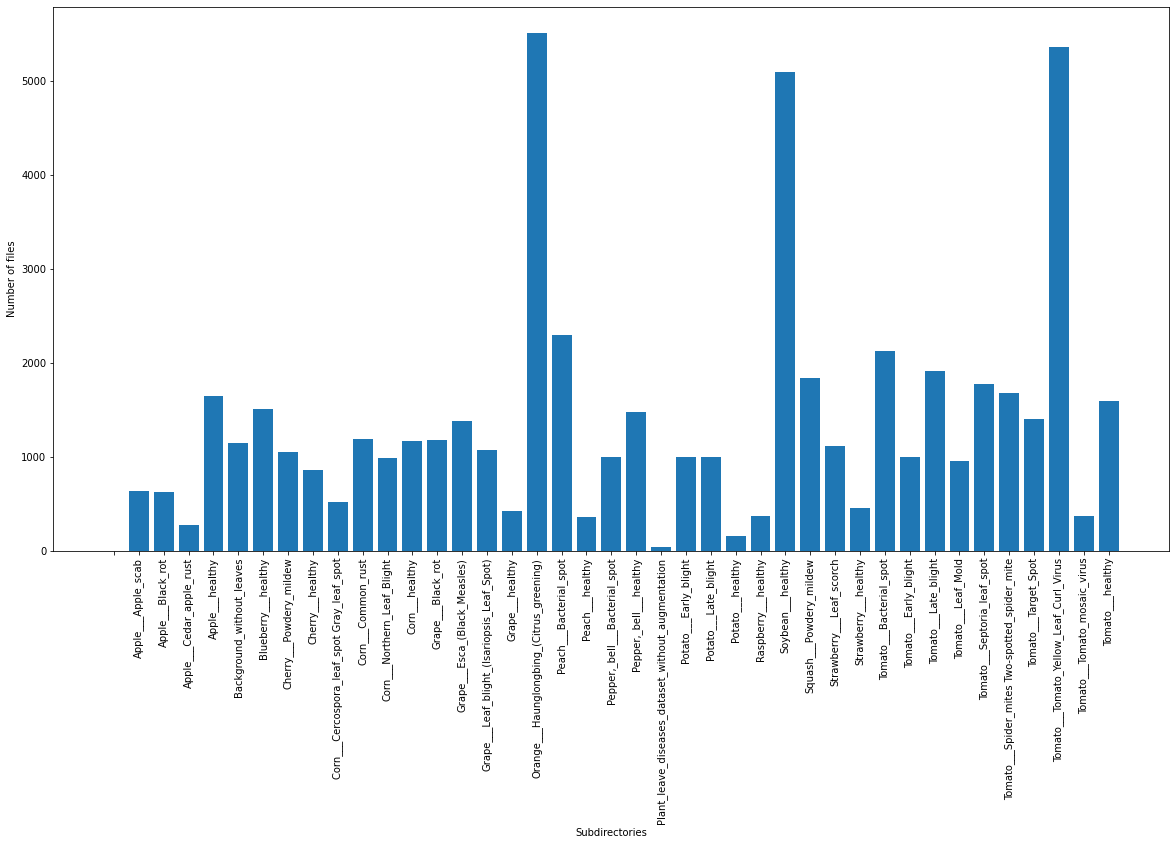

In [16]:
import matplotlib.pyplot as plt
sorted_keys = sorted(dir_count.keys())
plt.figure(figsize=(20, 10))
plt.bar(sorted_keys, [dir_count[key] for key in sorted_keys])
plt.xticks(rotation=90)
plt.xlabel('Subdirectories')
plt.ylabel('Number of files')
#
plt.show()

Let's get 10 images from folders that include the word "healthy" and contain "similar" leaves to Cannabis.

This will be the images to use with the "healthy" label.

In [32]:
from pathlib import Path
from zipfile import ZipFile
import random


# specify the zip file and the target directory

zip_filepath = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'
target_dir = '/content/'

dir_names = ["Apple","Grape","Pepper,_bell","Potato","Raspberry","Soybean","Strawberry"]
# open the zip file
with ZipFile(zip_filepath, 'r') as zip_ref:
    # iterate through the directories within the zip file
    for directory in (f for f in zip_ref.namelist() if f.endswith('/')):
      # Check if the directory name contains both an entry from the dir_names list as well as the word "healthy"
      if any(name in directory for name in dir_names) and "healthy" in directory:
        print(f"{directory}")
        files = zip_ref.namelist()
        files = [file for file in files if directory in file]
        # take a random sample of files from the directory.
        files = random.sample(files,10)
        for file in files:
            zip_ref.extract(file, target_dir)





Plant_leave_diseases_dataset_without_augmentation/Apple___healthy/
Plant_leave_diseases_dataset_without_augmentation/Grape___healthy/
Plant_leave_diseases_dataset_without_augmentation/Pepper,_bell___healthy/
Plant_leave_diseases_dataset_without_augmentation/Potato___healthy/
Plant_leave_diseases_dataset_without_augmentation/Raspberry___healthy/
Plant_leave_diseases_dataset_without_augmentation/Soybean___healthy/
Plant_leave_diseases_dataset_without_augmentation/Strawberry___healthy/


In [3]:
import zipfile
import os

my_dir = '/content/'
my_zip = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'

with zipfile.ZipFile(my_zip) as zip:

    for zip_info in zip.infolist():
        print(f"There are a total of: {len(zip.infolist())}    zip_info {zip_info}.  ")
        if zip_info.filename[-1] == '/':
            continue
        zip_info.filename = os.path.basename(zip_info.filename)
        # print(f"{zip_info.filename}")

Streaming output truncated to the last 5000 lines.
There are a total of: 55488    zip_info <ZipInfo filename='Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG' compress_type=deflate external_attr=0x20 file_size=16101 compress_size=15924>.  
There are a total of: 55488    zip_info <ZipInfo filename='Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG' compress_type=deflate external_attr=0x20 file_size=9643 compress_size=9496>.  
There are a total of: 55488    zip_info <ZipInfo filename='Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG' compress_type=deflate external_attr=0x20 file_size=17555 compress_size=17391>.  
There are a total of: 55488    zip_info <ZipInfo filename='Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG' compress_type=deflate external_attr=0x20 file

In [35]:
from pathlib import Path
from zipfile import ZipFile
import random


# specify the zip file and the target directory

zip_filepath = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'
target_dir = '/content/healthy/'
# Path.mkdir('/content/healthy')
dir_names = ["Apple","Grape","Pepper,_bell","Potato","Raspberry","Soybean","Strawberry"]
# open the zip file
with ZipFile(zip_filepath, 'r') as zip_ref:
    # iterate through the directories within the zip file
    for directory in (f for f in zip_ref.namelist() if f.endswith('/')):
      # Check if the directory name contains both an entry from the dir_names list as well as the word "healthy"
      if any(name in directory for name in dir_names) and "healthy" in directory:
        files = zip_ref.namelist()
        files = [file for file in files if directory in file]
        # take a random sample of files from the directory.
        files = random.sample(files,10)
        dir_path = Path(directory)
        subdir_name = dir_path.parts[-1]
        for name in dir_names:
           if name in subdir_name:
              short_dir_name = name
              break

        for file in files:
            zip_info = zip_ref.getinfo(file)
            zip_info.filename = zip_info.filename.replace("image",short_dir_name)
            zip_info.filename = Path(zip_info.filename).name
            print(f"{zip_info.filename}")
            zip_ref.extract(zip_info, target_dir)





Apple (1236).JPG
Apple (79).JPG
Apple (368).JPG
Apple (1437).JPG
Apple (1148).JPG
Apple (224).JPG
Apple (1126).JPG
Apple (1587).JPG
Apple (1301).JPG
Apple (578).JPG
Total number of images in the /content/healthy/ directory is 10
Grape (44).JPG
Grape (381).JPG
Grape (262).JPG
Grape (78).JPG
Grape (167).JPG
Grape (270).JPG
Grape (97).JPG
Grape (27).JPG
Grape (144).JPG
Grape (390).JPG
Total number of images in the /content/healthy/ directory is 10
Pepper,_bell (80).JPG
Pepper,_bell (264).JPG
Pepper,_bell (914).JPG
Pepper,_bell (1016).JPG
Pepper,_bell (115).JPG
Pepper,_bell (254).JPG
Pepper,_bell (260).JPG
Pepper,_bell (1078).JPG
Pepper,_bell (1433).JPG
Pepper,_bell (448).JPG
Total number of images in the /content/healthy/ directory is 10
Potato (12).JPG
Potato (138).JPG
Potato (28).JPG
Potato (114).JPG
Potato (77).JPG
Potato (25).JPG
Potato (149).JPG
Potato (60).JPG
Potato (66).JPG
Potato (112).JPG
Total number of images in the /content/healthy/ directory is 10
Raspberry (337).JPG
Raspber

In [31]:
from pathlib import Path

subdir = 'Plant_leave_diseases_dataset_without_augmentation/Soybean___healthy/'
subdir_path = Path(subdir)
dir_names = ["Apple","Grape","Pepper,_bell","Potato","Raspberry","Soybean","Strawberry"]

# Get the name of the subdirectory
subdir_name = subdir_path.parts[-1]

# Check if the subdirectory name contains an entry from the dir_names list
for name in dir_names:
    if name in subdir_name:
        short_dir_name = name
        print(f"{short_dir_name}")
        break


Soybean


In [15]:
my_image = "Plant_leave_diseases_dataset_without_augmentation/Apple___healthy/image (1099).JPG"
my_image = my_image.replace("image", "Apple")
my_image

'Plant_leave_diseases_dataset_without_augmentation/Apple___healthy/Apple (1099).JPG'

In [ ]:
with zipfile.ZipFile("/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip", "r") as zip_ref:
  print(f"{zip_ref}")

<zipfile.ZipFile filename='/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip' mode='r'>


In [ ]:
import zipfile
from pathlib import Path

# Open the zip file
cwd = Path.cwd()

with zipfile.ZipFile("/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip", "r") as zip_ref:
    # Extract 10 files from the "Apple_healthy" folder
    print(f"current working directory: {cwd} list of zipfiles: {zip_ref.namelist()}")
    healthy_images = [zip_ref.read(img) for img in zip_ref.namelist() if "Apple_healthy" in img and img.endswith(".jpg")][:10]
    print(f"healthy images: {healthy_images}")
    for i, img_data in enumerate(healthy_images):
        with open(f'Apple_healthy_{i}.jpg', "wb") as f:
          print(f"filename: Apple_health{i}.jpg")
          f.write(img_data)
    print(f"10 files from the 'Apple_healthy' folder have been extracted and saved in your Colab storage.")


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
downloader = Downloader(url, content)
downloader.download()
downloader.extract()

filename: view?usp=sharing
Mounted at /content/drive


NameError: ignored

In [ ]:
import zipfile
from pathlib import Path

# Open the zip file
with zipfile.ZipFile("plant_village.zip", "r") as zip_ref:
    # Get a list of all subdirectories in the zip file
    subdirs = [Path(x.filename) for x in zip_ref.infolist() if x.filename.endswith("/")]

  "Apple__healthy",
  /content/Plant_leave_diseases_dataset_without_augmentation/Apple___healthy

  /content/Plant_leave_diseases_dataset_without_augmentation/Grape___healthy

  /content/Plant_leave_diseases_dataset_without_augmentation/Pepper,_bell___healthy

  /content/Plant_leave_diseases_dataset_without_augmentation/Potato___healthy  


/content/Plant_leave_diseases_dataset_without_augmentation/Raspberry___healthy

/content/Plant_leave_diseases_dataset_without_augmentation/Soybean___healthy


/content/Plant_leave_diseases_dataset_without_augmentation/Strawberry___healthy







{
 "class_names": [
  "Peach_healthy",
  "Strawberry_leaf_scorch",
  "Grape_black_measles",
  "Tomato_septoria_leaf_spot",
  "Grape_healthy",
  "Tomato_healthy",
  "Peach_bacterial_spot",
  "Corn_gray_leaf_spot",
  "Soybean_healthy",
  "Corn_common_rust",
  "Blueberry_healthy",
  "Corn_healthy",
  "Apple_healthy",
  "Apple_cedar_apple_rust",
  "Background_without_leaves",
  "Tomato_target_spot",
  "Pepper_healthy",
  "Grape_black_rot",
  "Apple_scab",
  "Raspberry_healthy",
  "Tomato_early_blight",
  "Tomato_yellow_leaf_curl_virus",
  "Corn_northern_leaf_blight",
  "Potato_healthy",
  "Tomato_late_blight",
  "Cherry_powdery_mildew",
  "Grape_leaf_blight",
  "Tomato_leaf_mold",
  "Pepper_bacterial_spot",
  "Potato_late_blight",
  "Tomato_mosaic_virus",
  "Potato_early_blight",
  "Tomato_bacterial_spot",
  "Strawberry_healthy",
  "Cherry_healthy",
  "Squash_powdery_mildew",
  "Tomato_spider_mites_two-spotted_spider_mite",
  "Orange_haunglongbing",
  "Apple_black_rot"
 ]
}

{
 "class_names": [
  "Peach_healthy",
  "Strawberry_leaf_scorch",
  "Grape_black_measles",
  "Tomato_septoria_leaf_spot",
  "Grape_healthy",
  "Tomato_healthy",
  "Peach_bacterial_spot",
  "Corn_gray_leaf_spot",
  "Soybean_healthy",
  "Corn_common_rust",
  "Blueberry_healthy",
  "Corn_healthy",
  "Apple_healthy",
  "Apple_cedar_apple_rust",
  "Background_without_leaves",
  "Tomato_target_spot",
  "Pepper_healthy",
  "Grape_black_rot",
  "Apple_scab",
  "Raspberry_healthy",
  "Tomato_early_blight",
  "Tomato_yellow_leaf_curl_virus",
  "Corn_northern_leaf_blight",
  "Potato_healthy",
  "Tomato_late_blight",
  "Cherry_powdery_mildew",
  "Grape_leaf_blight",
  "Tomato_leaf_mold",
  "Pepper_bacterial_spot",
  "Potato_late_blight",
  "Tomato_mosaic_virus",
  "Potato_early_blight",
  "Tomato_bacterial_spot",
  "Strawberry_healthy",
  "Cherry_healthy",
  "Squash_powdery_mildew",
  "Tomato_spider_mites_two-spotted_spider_mite",
  "Orange_haunglongbing",
  "Apple_black_rot"
 ]
}

# Define a Subset of the Dataset
- Go to [Plant Village query page](https://app.activeloop.ai/activeloop/plantvillage-without-augmentation/08130113ea9ac322dbefc20d26797defa682a87f?vs=eyJsaSI6eyJjIjpbeyJoIjpmYWxzZSwibiI6ImltYWdlcyIsIm8iOjEuMH0seyJoIjpmYWxzZSwibiI6ImxhYmVscyIsIm8iOjAuNjk5OTk5OTg4MDc5MDcxfV0sImgiOmZhbHNlLCJuIjoiZGVmYXVsdCIsIm8iOjEuMH0sInJpIjp7ImNmIjpbLTEuMCwwLjAsMC4wXSwiY2kiOlswLjAsLTMuMTQxNTkyNzQxMDEyNTczMl0sImNtIjoxLjAsImNwIjpbNC4wLDEuMjAwMDAwMDQ3NjgzNzE1OCwtMS4xOTk5OTY5NDgyNDIxODc1XSwib2kiOjI2NDQ2fX0=).  Here we can view, filter

# Download the Plant Village (Without Augmentation) Dataset
The dataset will then be available by accessing the `ds` variables.

In [ ]:
!pip -q install deeplake
import deeplake
ds = deeplake.load('hub://activeloop/plantvillage-without-augmentation')


In [ ]:
view = ds.query('Query string')

In [ ]:
import deeplake
ds = deeplake.load('hub://activeloop/plantvillage-without-augmentation')
# Indexing
image = ds.images[0:1000].numpy() # Fetch the first 1000 images and return a numpy array of them

In [ ]:
image.shape

## Check out Characteristics of the Dataset


In [ ]:
ds.tensors.keys()

In [ ]:
ds.labels

In [ ]:
ds.summary()

In [ ]:
views = ds.get_views()
views

 63c9b146e524074050da86e0 is the id to the small ds view i created.

In [ ]:
ds_view = ds.query('select * where contains(labels, "Strawberry_leaf_scorch") limit 100 union select * where contains(labels, "Strawberry_healthy") limit 100')


In [ ]:
ds.visualize()